In [1]:
import numpy as np
from numpy import float64 as realN
from numba import jit
from numba.typed import Dict

import tikzplotlib

from DaTaReachControl.interval import *
from DaTaReachControl import DaTaReach, initOverApprox, fover, Gover
from DaTaReachControl import generateTraj, synthNextState, synthTraj
from DaTaReachControl import depTypeF, depTypeG, depTypeGradF, depTypeGradG
from DaTaReachControl import depTypebf, depTypebG

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
##### Define the Unicycle system dynamics and the initial trajectory is generated ###
#####################################################################################

# Turn to true if you want to save the .tex images
saveTex = False

# Define a seed for repeatability
np.random.seed(2339) # 3626 923 sexy traj: (3963 c_vmax =  1.0 c_wmax =  1.5 c_rot = 5)
# val = int(np.random.uniform(0,4000))
# print (val)
# np.random.seed(val)

# Sampling time
sampling_time = 0.1

# Define the initial satte and the axis limits
initial_state = np.array([-2, -2.5, np.pi/2])

# Number of data in initial trajectory
n_data_max = 15

# Input bounds
v_max = 4
w_max = 0.5 * (2*np.pi)
v_min = -v_max
w_min = -w_max
input_lb = np.array([v_min, w_min])
input_ub = np.array([v_max, w_max])

# Generate random input sequence --> put some random zero
# in some direction of the control to have a trajectory with certain quality
v_seq = -1 *(np.random.rand(n_data_max,1) - 0) * v_max # 2 * (np.random.rand(n_data_max,1) - 0.5) * v_max
w_seq = 2 * (np.random.rand(n_data_max,1) - 0.5) * w_max
# Number of data points with potentially zero for the value of the control in a direction
nSep = int(n_data_max /2)
# Randomly pick the indexes with zero control in a random direction
sepIndexes = np.random.choice([ i for i in range(n_data_max)], nSep, replace=False)
for i in range(1,nSep):
    zero_or_no = np.random.choice([0,1], p=[0.2,0.8])
    if zero_or_no == 0:
        w_seq[sepIndexes[i],0] = 0
        v_seq[sepIndexes[i],0] = 0
        continue
    v_or_theta = np.random.choice([0,1], p=[0.4,0.6])
    if v_or_theta == 0: # pick v
        w_seq[sepIndexes[i],0] = 0
    else: # pick theta
        v_seq[sepIndexes[i],0] = 0
rand_control = np.hstack((v_seq,w_seq))
# print (rand_init_input_vec)

# Input signal to evaluate a trajectory of the system
c_vmax =  1.0
c_wmax =  1.
c_rot = 6
t_end = (n_data_max-1) * sampling_time

# Build the uncertain control (here, there is no uncertaincy)
@jit(nopython=True, parallel=False, fastmath=True)
def uOver(t_lb, t_ub):
    x_lb = np.empty(2, dtype=realN)
    x_ub = np.empty(2, dtype=realN)
    if t_lb < t_end+(1.0*sampling_time)-epsTolInt:
        indx = int(t_lb / sampling_time)
        x_lb[:] = rand_control[indx,:]
        x_ub[:] = rand_control[indx,:]
        return x_lb, x_ub 
    x_lb[0] = c_vmax
    x_ub[0] = c_vmax
    x_lb[1], x_ub[1] = cos_i(c_rot*(t_lb-t_end), c_rot*(t_ub-t_end))
    x_lb[1], x_ub[1] = mul_i_scalar(x_lb[1], x_ub[1], c_wmax)
    return x_lb, x_ub

# Unknown dynamics of the unicycle
def fFun(x):
    return np.zeros(3, dtype=np.float64)
def GFun(x):
    return np.array([[np.cos(x[2]), 0], [np.sin(x[2]), 0], [0.0, 1.0]])
# Use the uncertain control above as the control signal to generate a trajectory
def uFun(t):
    u_t, _ = uOver(t, t)
    return u_t.reshape(-1,1)

# Generate a more precise trajectory with smaller sample time based on the control
# ufun by solving numerically the ODE with the true dynamics
nPoint = 81
dt = 0.05 # Delta time of the computed trajectory

# Create the time tables
tVal_1 = np.array([ i*dt for i in range(nPoint+1)])
tMeas = np.array([i*sampling_time for i in range(n_data_max)])
# Obtain the trajectory via ode solver
tVal_1, traj, trajDot = synthTraj(fFun, GFun, uFun, initial_state, tVal_1, atol=1e-10, rtol=1e-10)
tVal = tVal_1[:-1] # Obtain the list of time before the last time
# Create a table with the control values applied at each time step dt
u_values = np.empty((nPoint, rand_control.shape[1]), dtype=np.float64)
for i in range(u_values.shape[0]):
    t_lb, t_ub = uOver(tVal[i], tVal[i])
    u_values[i,:] = t_lb

# Construct the state evolution and the state derivative evolution
x_values = traj[:,:]
xdot_values = trajDot[:-1,:]

# Generate the trajectory corresponding to random input sequence
rand_init_traj_vec = np.zeros((n_data_max + 1, initial_state.size), dtype=np.float64)
rand_init_traj_der_vec = np.zeros((n_data_max, initial_state.size), dtype=np.float64)
rand_init_input_vec = np.zeros((n_data_max, rand_control.shape[1]), dtype=np.float64)


repeat_val = int(sampling_time/dt)
# Now redefine the state and their derivative
for i in range(0, repeat_val*rand_control.shape[0], repeat_val):
    rand_init_input_vec[int(i/repeat_val),:] = u_values[i,:] 
    rand_init_traj_der_vec[int(i/repeat_val),:] = xdot_values[i,:]
    rand_init_traj_vec[int(i/repeat_val),:] = x_values[i,:]
rand_init_traj_vec[-1,:] = x_values[repeat_val*rand_control.shape[0],:]

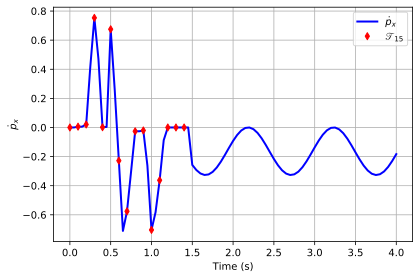

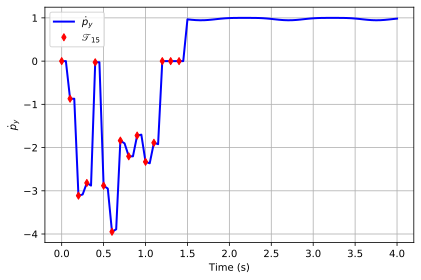

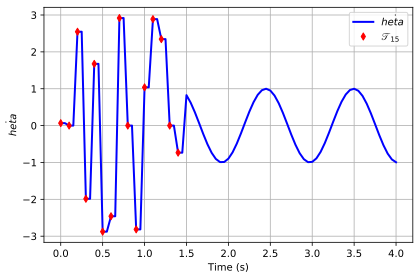

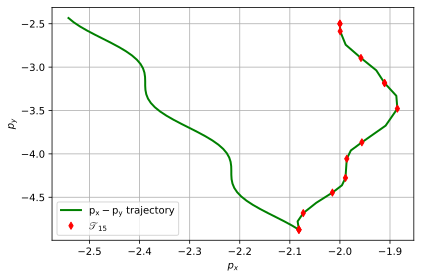

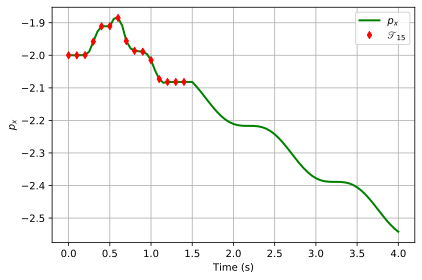

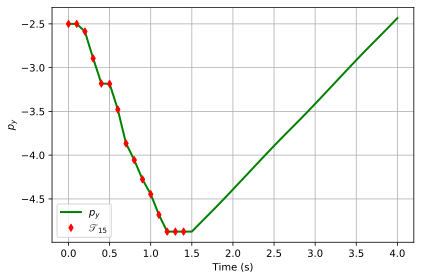

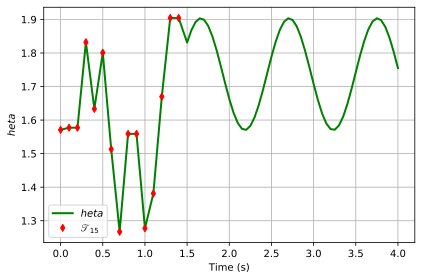

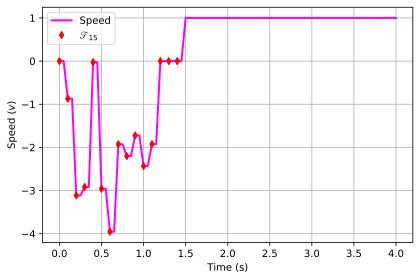

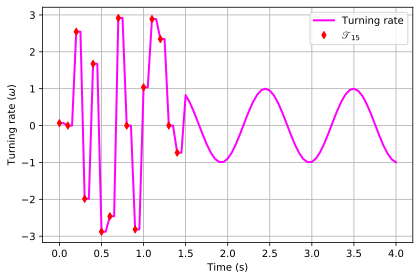

In [4]:
# Preview the trajectory
# plt.style.use('dark_background')
lwidth = 2
mSize = 5
markerTraj = 'rd'

plt.figure()
plt.plot(tVal, xdot_values[:,0], "blue", linewidth=lwidth, label='$\dot{p}_x$')
plt.plot(tMeas, rand_init_traj_der_vec[:,0], markerTraj, markerSize=mSize, label='$\mathscr{T}_{'+ str(tMeas.shape[0])+'}$')
plt.xlabel('Time (s)')
plt.ylabel('$\dot{p}_x$')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(tVal, xdot_values[:,1], "blue", linewidth=lwidth, label='$\dot{p}_y$')
plt.plot(tMeas, rand_init_traj_der_vec[:,1], markerTraj, markerSize=mSize, label='$\mathscr{T}_{'+ str(tMeas.shape[0])+'}$')
plt.xlabel('Time (s)')
plt.ylabel('$\dot{p}_y$')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(tVal, xdot_values[:,2], "blue", linewidth=lwidth, label='$\dot{\theta}$')
plt.plot(tMeas, rand_init_traj_der_vec[:,2], markerTraj, markerSize=mSize, label='$\mathscr{T}_{'+ str(tMeas.shape[0])+'}$')
plt.xlabel('Time (s)')
plt.ylabel('$\dot{\theta}$')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(x_values[:-1,0], x_values[:-1,1], 'green', linewidth=lwidth, label='$\mathrm{p_x-p_y \ trajectory}$')
plt.plot(rand_init_traj_vec[:-1,0], rand_init_traj_vec[:-1,1], markerTraj, markerSize=mSize, label='$\mathscr{T}_{'+ str(tMeas.shape[0])+'}$')    
plt.xlabel('$p_x$')
plt.ylabel('$p_y$')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(tVal, x_values[:-1,0], "green", linewidth=lwidth, label='$p_x$')
plt.plot(tMeas, rand_init_traj_vec[:-1,0], markerTraj, markerSize=mSize, label='$\mathscr{T}_{'+ str(tMeas.shape[0])+'}$')
plt.xlabel('Time (s)')
plt.ylabel('$p_x$')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
if saveTex:
    tikzplotlib.save('figs/px_unicycle_evolution.tex')
plt.show()

plt.figure()
plt.plot(tVal, x_values[:-1,1], "green", linewidth=lwidth, label='$p_y$')
plt.plot(tMeas, rand_init_traj_vec[:-1,1], markerTraj, markerSize=mSize, label='$\mathscr{T}_{'+ str(tMeas.shape[0])+'}$')
plt.xlabel('Time (s)')
plt.ylabel('$p_y$')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
if saveTex:
    tikzplotlib.save('figs/py_unicycle_evolution.tex')
plt.show()

plt.figure()
plt.plot(tVal, x_values[:-1,2], "green", linewidth=lwidth, label='$\theta$')
plt.plot(tMeas, rand_init_traj_vec[:-1,2], markerTraj, markerSize=mSize, label='$\mathscr{T}_{'+ str(tMeas.shape[0])+'}$')
plt.xlabel('Time (s)')
plt.ylabel('$\theta$')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
if saveTex:
    tikzplotlib.save('figs/theta_unicycle_evolution.tex')
plt.show()

plt.figure()
plt.plot(tVal, u_values[:,0], "magenta", linewidth = lwidth, label='$\mathrm{Speed}$')
plt.plot(tMeas, rand_init_input_vec[:,0], markerTraj, markerSize=mSize, label='$\mathscr{T}_{'+ str(tMeas.shape[0])+'}$')
plt.xlabel('Time (s)')
plt.ylabel('$\mathrm{Speed}$ $(v)$')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
if saveTex:
    tikzplotlib.save('figs/v_unicycle_evolution.tex')
plt.show()

plt.figure()
plt.plot(tVal, u_values[:,1], "magenta", linewidth = lwidth, label='$\mathrm{Turning\ rate}$')
plt.plot(tMeas, rand_init_input_vec[:,1], markerTraj, markerSize=mSize, label='$\mathscr{T}_{'+ str(tMeas.shape[0])+'}$')
plt.xlabel('Time (s)')
plt.ylabel('$\mathrm{Turning\ rate}$ $(\omega)$')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
if saveTex:
    tikzplotlib.save('figs/omega_unicycle_evolution.tex')
plt.show()

In [5]:
# Build the over-approximations of f and G
Lf = np.array([0.01, 0.01, 0.01], dtype=realN) # Lipschitz constant of f
LG = np.array([[1.1,0],[1.1,0],[0,0.01]], dtype=realN)

Lf_ca = np.array([0.0, 0.0, 0.0], dtype=realN)
LG_ca = np.array([[1,0],[1,0],[0,0]], dtype=realN)

nDepf = Dict(*depTypeF)
nDepf[0] = np.array([0,1], dtype=np.int64)
nDepf[1] = np.array([0,1], dtype=np.int64)
nDepf[2] = np.array([0,1], dtype=np.int64)

nDepGnt = Dict(*depTypeG)
nDepGnt[(0,0)] = np.array([0,1],dtype=np.int64)
nDepGnt[(1,0)] = np.array([0,1],dtype=np.int64)
nDepGnt[(2,1)] = np.array([0,1],dtype=np.int64)

nDepG = Dict(*depTypeG)
nDepG[(0,0)] = np.array([0,1],dtype=np.int64)
nDepG[(1,0)] = np.array([0,1],dtype=np.int64)
nDepG[(2,1)] = np.array([0,1],dtype=np.int64)

@jit(nopython=True)
def knownGfun(x_lb, x_ub):
    res_lb = np.zeros((3,2),dtype=realN)
    res_ub = np.zeros((3,2),dtype=realN)
    return res_lb, res_ub

@jit(nopython=True)
def knownGfunTight(x_lb, x_ub):
    res_lb = np.zeros((3,2),dtype=realN)
    res_ub = np.zeros((3,2),dtype=realN)
    res_lb[2,1] = 1
    res_ub[2,1] = 1
    return res_lb, res_ub

In [6]:
overApprox_nodep = initOverApprox(Lf, LG,  Lfknown=None, LGknown=None, nvDepF=depTypeF,
        nvDepG=nDepGnt, bf=depTypebf , bG =depTypebG , bGf = depTypeGradF,
        bGG=depTypeGradG, xTraj=rand_init_traj_vec, xDotTraj=rand_init_traj_der_vec, 
        uTraj=rand_init_input_vec, useGronwall=True, verbose=False, Gknown=knownGfun)

overApprox = initOverApprox(Lf, LG,  Lfknown=None, LGknown=None, nvDepF=nDepf,
        nvDepG=nDepG, bf=depTypebf , bG =depTypebG , bGf = depTypeGradF,
        bGG=depTypeGradG, xTraj=rand_init_traj_vec, xDotTraj=rand_init_traj_der_vec, 
        uTraj=rand_init_input_vec, useGronwall=True, verbose=False, Gknown=knownGfun)

overApprox_f0 = initOverApprox(Lf_ca, LG_ca,  Lfknown=None, LGknown=None, nvDepF=nDepf,
        nvDepG=nDepG, bf=depTypebf , bG =depTypebG , bGf = depTypeGradF,
        bGG=depTypeGradG, xTraj=rand_init_traj_vec, xDotTraj=rand_init_traj_der_vec, 
        uTraj=rand_init_input_vec, useGronwall=True, verbose=False, Gknown=knownGfunTight)

In [7]:
# Compute over-approximation at each point in x_values
xdot_lb = np.zeros((nPoint, x_values.shape[1]))
xdot_ub = np.zeros((nPoint, x_values.shape[1]))
for i in range(nPoint):
    f_lb, f_ub = fover(overApprox, x_values[i,:], x_values[i,:])
    G_lb, G_ub = Gover(overApprox, x_values[i,:], x_values[i,:], knownG=knownGfun)
    xdot_lb[i,:], xdot_ub[i,:] = add_i(f_lb, f_ub, *mul_Ms_i(G_lb, G_ub, u_values[i,:]))

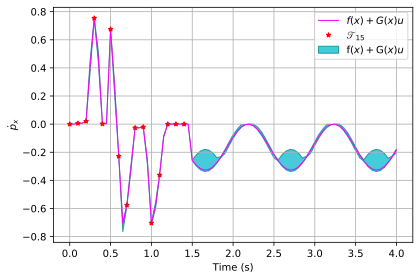

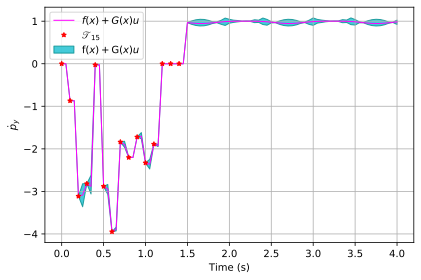

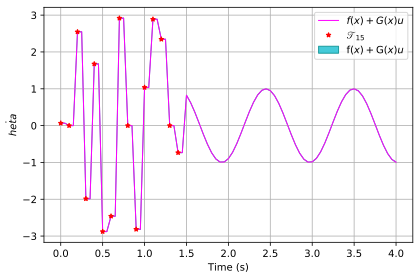

In [8]:
# Plot the over-approximation of the reachable set
# plt.style.use('dark_background')

# First plot the state evolution
plt.figure()
plt.plot(tVal, xdot_values[:,0], "magenta", linewidth=1, label='$f(x) + G(x) u$')
plt.plot(tMeas, rand_init_traj_der_vec[:,0], 'r*', markerSize=5, label='$\mathscr{T}_{'+ str(tMeas.shape[0])+'}$')
plt.fill_between(tVal, xdot_lb[:,0], xdot_ub[:,0], alpha=0.8, facecolor="tab:cyan", edgecolor= "darkcyan",
                 linewidth=1, label='$\mathrm{f}(x) + \mathrm{G}(x) u$')
plt.xlabel('Time (s)')
plt.ylabel('$\dot{p}_x$')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
if saveTex:
    tikzplotlib.save('figs/derpx_unicycle_evolution.tex')
plt.show()

plt.figure()
plt.plot(tVal, xdot_values[:,1], "magenta", linewidth = 1, label='$f(x) + G(x) u$')
plt.plot(tMeas, rand_init_traj_der_vec[:,1], 'r*', markerSize=5, label='$\mathscr{T}_{'+ str(tMeas.shape[0])+'}$')
plt.fill_between(tVal, xdot_lb[:,1], xdot_ub[:,1], alpha=0.8, facecolor="tab:cyan", edgecolor= "darkcyan",
                 linewidth=1, label='$\mathrm{f}(x) + \mathrm{G}(x) u$')
plt.xlabel('Time (s)')
plt.ylabel('$\dot{p}_y$')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
if saveTex:
    tikzplotlib.save('figs/derpy_unicycle_evolution.tex')
plt.show()

plt.figure()
plt.plot(tVal, xdot_values[:,2], "magenta", linewidth = 1, label='$f(x) + G(x) u$')
plt.plot(tMeas, rand_init_traj_der_vec[:,2], 'r*', markerSize=5, label='$\mathscr{T}_{'+ str(tMeas.shape[0])+'}$')
plt.fill_between(tVal, xdot_lb[:,2], xdot_ub[:,2], alpha=0.8, facecolor="tab:cyan", edgecolor= "darkcyan", 
                 linewidth=1, label='$\mathrm{f}(x) + \mathrm{G}(x) u$')
plt.xlabel('Time (s)')
plt.ylabel('$\dot{\theta}$')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
if saveTex:
    tikzplotlib.save('figs/dertheta_unicycle_evolution.tex')
plt.show()

In [9]:
# Define the uncertain control input
# pert_lb = np.array([-0.02,-0.01])
# pert_ub = np.array([0.02, 0.01])
# pert_lb = np.array([-0.0,-0.01])
# pert_ub = np.array([0.0, 0.01])
pert_lb = np.array([-0.1,-0.01])
pert_ub = np.array([0.1, 0.01])

@jit(nopython=True, parallel=False, fastmath=True)
def uOverPert(t_lb, t_ub, pertU_lb=pert_lb, pertU_ub=pert_ub):
    x_lb = np.empty(2, dtype=realN)
    x_ub = np.empty(2, dtype=realN)
    if t_lb < t_end+(1.0*sampling_time)-epsTolInt:
        indx = int(t_lb / sampling_time)
        x_lb[:] = rand_control[indx,:]
        x_ub[:] = rand_control[indx,:]
        return x_lb, x_ub 
    x_lb[0] = c_vmax
    x_ub[0] = c_vmax
    x_lb[1], x_ub[1] = cos_i(c_rot*(t_lb-t_end), c_rot*(t_ub-t_end))
    x_lb[1], x_ub[1] = mul_i_scalar(x_lb[1], x_ub[1], c_wmax)
    # pert_mul_lb, pert_mul_ub = mul_i(pert_lb, pert_ub, t_lb, t_ub)
    # return x_lb + pert_mul_lb, x_ub + pert_mul_ub
    
    # print(t_lb, t_ub, x_lb+pertU_lb, x_ub+pertU_ub)
    return x_lb+pertU_lb, x_ub+pertU_ub

@jit(nopython=True, parallel=False, fastmath=True)
def uOverDerPert(t_lb, t_ub, pertU_lb=pert_lb, pertU_ub=pert_ub):
    x_lb = np.zeros(2, dtype=realN)
    x_ub = np.zeros(2, dtype=realN)
    if t_lb < t_end+(1.0*sampling_time)-epsTolInt:
        return x_lb, x_ub
    x_lb[1], x_ub[1] = sin_i(c_rot*(t_lb-t_end), c_rot*(t_ub-t_end))
    x_lb[1], x_ub[1] = mul_i_scalar(x_lb[1], x_ub[1], -c_wmax * c_rot)
    # return x_lb + pertU_lb, x_ub + pertU_ub
    # print('der',t_lb, t_ub, x_lb, x_ub)
    return x_lb, x_ub

# time step for for the reachable sets computation
dt_reach = 0.02
repeat_val = int(sampling_time/dt_reach)
nPoint = int((tVal[-1]) / dt_reach)
tValOver = np.array([ i*dt_reach for i in range(nPoint+1)])

# Discretize the pertubation
nTile = 100
v_tiling = np.linspace(pert_lb[0], pert_ub[0], nTile)
w_tiling = np.linspace(pert_lb[1], pert_ub[1], nTile)

In [ ]:
def trueReachableSet(discreteTime, stateInit):
    """ Compute the btrue reachable set based on the Subdivion by nTile"""
    res_lb = np.empty((discreteTime.shape[0], stateInit.shape[0]), dtype=realN)
    res_ub = np.empty((discreteTime.shape[0], stateInit.shape[0]), dtype=realN)
    for i in range(nTile):
        def uFun(t):
            u_t, _ = uOverPert(t, t, pertU_lb=np.array([v_tiling[i], w_tiling[i]]), pertU_ub=np.array([v_tiling[i], w_tiling[i]]))
            return u_t.reshape(-1,1)
        _, traj, trajDot = synthTraj(fFun, GFun, uFun, stateInit, discreteTime, atol=1e-10, rtol=1e-10)
        if i == 0:
            res_lb = traj
            res_ub = traj
            continue
        res_lb = np.minimum(res_lb, traj)
        res_ub = np.maximum(res_ub, traj)
    return res_lb, res_ub

# @jit(nopython=True, parallel=False, fastmath=True)
def reachSet(overApprox, funF=None, funG=None):
    res_lb = np.empty((tValOver.shape[0], x_values.shape[1]), dtype=realN)
    res_ub = np.empty((tValOver.shape[0], x_values.shape[1]), dtype=realN)
    res_lb[0,:] = rand_init_traj_vec[0,:]
    res_ub[0,:] = rand_init_traj_vec[0,:]
    for i in range(rand_init_input_vec.shape[0]):
        curr_x = rand_init_traj_vec[i,:]
        curr_u = rand_init_input_vec[i,:]
        temp, x_lb, x_ub = DaTaReach(overApprox, curr_x, curr_x, tMeas[i], repeat_val, dt_reach, 
                                uOverPert, uOverDerPert, knownf=funF, knownG=funG)
        for p in range(repeat_val):
            res_lb[i*repeat_val+p+1,:] = x_lb[p+1,:]
            res_ub[i*repeat_val+p+1,:] = x_ub[p+1,:]
    _, x_lb, x_ub = DaTaReach(overApprox, rand_init_traj_vec[-1,:], rand_init_traj_vec[-1,:], 
                        t_end+sampling_time, tValOver.shape[0]-1-repeat_val*rand_init_input_vec.shape[0], 
                        dt_reach, uOverPert, uOverDerPert, knownf=funF, knownG=funG)
    for p in range(x_lb.shape[0]-1):
        res_lb[repeat_val*rand_init_input_vec.shape[0]+p+1,:] = x_lb[p+1,:]
        res_ub[repeat_val*rand_init_input_vec.shape[0]+p+1,:] = x_ub[p+1,:]
    return res_lb, res_ub    

In [ ]:
reach_lb, reach_ub = trueReachableSet(tValOver, initial_state)
datareach_nd_lb, datareach_nd_ub = reachSet(overApprox_nodep, funF=None, funG=knownGfun)
datareach_d_lb, datareach_d_ub = reachSet(overApprox, funF=None, funG=knownGfun)
datareach_dt_lb, datareach_dt_ub = reachSet(overApprox_f0, funF=None, funG=knownGfunTight)

In [ ]:
# Plot the over-approximation of the reachable set
# plt.style.use('dark_background')

# First plot the state evolution
plt.figure()
plt.plot(tMeas, rand_init_traj_vec[:-1,0], markerTraj, markerSize=mSize, label='$\mathscr{T}_{'+ str(tMeas.shape[0])+'}$')
plt.fill_between(tValOver, datareach_nd_lb[:,0], datareach_nd_ub[:,0], alpha=0.8, facecolor="coral", edgecolor= "darksalmon",
                 linewidth=1, label='$\mathrm{DaTaReach,\ case\ (a)}$')
plt.fill_between(tValOver, datareach_d_lb[:,0], datareach_d_ub[:,0], alpha=0.8, facecolor="grey", edgecolor= "darkgrey",
                 linewidth=1, label='$\mathrm{DaTaReach,\ case\ (b)}$')
plt.fill_between(tValOver, datareach_dt_lb[:,0], datareach_dt_ub[:,0], alpha=0.8, facecolor="purple",edgecolor= "darkmagenta",
                 linewidth=1, label='$\mathrm{DaTaReach,\ case\ (c)}$')
plt.fill_between(tValOver, reach_lb[:,0], reach_ub[:,0], alpha=0.8, facecolor="tab:cyan", edgecolor= "darkcyan",
                 linewidth=1, label='$\mathrm{Reachable\ set}$')
plt.xlabel('Time (s)')
plt.ylabel('$p_x$')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
if saveTex:
    tikzplotlib.save('figs/pxreach_unicycle_evolution.tex')
plt.show()

plt.figure()
plt.plot(tMeas, rand_init_traj_vec[:-1,1], markerTraj, markerSize=5, label='$\mathscr{T}_{'+ str(tMeas.shape[0])+'}$')
plt.fill_between(tValOver, datareach_nd_lb[:,1], datareach_nd_ub[:,1], alpha=0.8, facecolor="coral", edgecolor= "darksalmon",
                 linewidth=1, label='$\mathrm{DaTaReach,\ case\ (a)}$')
plt.fill_between(tValOver, datareach_d_lb[:,1], datareach_d_ub[:,1], alpha=0.8, facecolor="grey", edgecolor= "darkgrey",
                 linewidth=1, label='$\mathrm{DaTaReach,\ case\ (b)}$')
plt.fill_between(tValOver, datareach_dt_lb[:,1], datareach_dt_ub[:,1], alpha=0.8, facecolor="purple",edgecolor= "darkmagenta",
                 linewidth=1, label='$\mathrm{DaTaReach,\ case\ (c)}$')
plt.fill_between(tValOver, reach_lb[:,1], reach_ub[:,1], alpha=0.8, facecolor="tab:cyan", edgecolor= "darkcyan",
                 linewidth=1, label='$\mathrm{Reachable\ set}$')
plt.xlabel('Time (s)')
plt.ylabel('$p_y$')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
if saveTex:
    tikzplotlib.save('figs/pyreach_unicycle_evolution.tex')
plt.show()

plt.figure()
plt.plot(tMeas, rand_init_traj_vec[:-1,2], markerTraj, markerSize=5, label='$\mathscr{T}_{'+ str(tMeas.shape[0])+'}$')
plt.fill_between(tValOver, datareach_nd_lb[:,2], datareach_nd_ub[:,2], alpha=0.8, facecolor="coral", edgecolor= "darksalmon",
                 linewidth=1, label='$\mathrm{DaTaReach,\ case\ (a)}$')
plt.fill_between(tValOver, datareach_d_lb[:,2], datareach_d_ub[:,2], alpha=0.8, facecolor="grey", edgecolor= "darkgrey",
                 linewidth=1, label='$\mathrm{DaTaReach,\ case\ (b)}$')
plt.fill_between(tValOver, datareach_dt_lb[:,2], datareach_dt_ub[:,2], alpha=0.8, facecolor="purple",edgecolor= "darkmagenta",
                 linewidth=1, label='$\mathrm{DaTaReach,\ case\ (c)}$')
plt.fill_between(tValOver, reach_lb[:,2], reach_ub[:,2], alpha=0.8, facecolor="tab:cyan", edgecolor= "darkcyan", 
                 linewidth=1, label='$\mathrm{Reachable\ set}$')
plt.xlabel('Time (s)')
plt.ylabel('$\theta$')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
if saveTex:
    tikzplotlib.save('figs/thetareach_unicycle_evolution.tex')
plt.show()


plt.figure()
plt.plot(x_values[:(rand_init_input_vec.shape[0]*int(sampling_time/dt)),0], 
        x_values[:(rand_init_input_vec.shape[0]*int(sampling_time/dt)),1], 'red', label='$\mathrm{Unknown\ trajectory}$')
plt.plot(rand_init_traj_vec[:-1,0], rand_init_traj_vec[:-1,1], markerTraj, label='$\mathscr{T}_{'+ str(tMeas.shape[0])+'}$')

first = True
for i in range(tValOver.shape[0]):
    x1_d,x2_d,y1_d,y2_d = datareach_nd_lb[i,0], datareach_nd_ub[i,0], datareach_nd_lb[i,1], datareach_nd_ub[i,1]
    if first:
        plt.fill([x1_d,x2_d,x2_d,x1_d], [y1_d,y1_d,y2_d,y2_d],\
                facecolor='coral', edgecolor='darksalmon', alpha=0.8,\
                label='$\mathrm{DaTaReach,\ case\ (a)}$')
        first = False
    
    plt.fill([x1_d,x2_d,x2_d,x1_d], [y1_d,y1_d,y2_d,y2_d],\
        alpha=0.8,facecolor='coral', edgecolor='darksalmon')

first = True
for i in range(tValOver.shape[0]):
    x1_d,x2_d,y1_d,y2_d = datareach_d_lb[i,0], datareach_d_ub[i,0], datareach_d_lb[i,1], datareach_d_ub[i,1]
    if first:
        plt.fill([x1_d,x2_d,x2_d,x1_d], [y1_d,y1_d,y2_d,y2_d],\
                facecolor='grey', edgecolor='darkgrey', alpha=0.8,\
                label='$\mathrm{DaTaReach,\ case\ (b)}$')
        first = False
    
    plt.fill([x1_d,x2_d,x2_d,x1_d], [y1_d,y1_d,y2_d,y2_d],\
        alpha=0.8,facecolor='grey', edgecolor='darkgrey')

first = True
for i in range(tValOver.shape[0]):
    x1_d,x2_d,y1_d,y2_d = datareach_dt_lb[i,0], datareach_dt_ub[i,0], datareach_dt_lb[i,1], datareach_dt_ub[i,1]
    if first:
        plt.fill([x1_d,x2_d,x2_d,x1_d], [y1_d,y1_d,y2_d,y2_d],\
                facecolor='purple', edgecolor='darkmagenta', alpha=0.8,\
                label='$\mathrm{DaTaReach,\ case\ (c)}$')
        first = False
    
    plt.fill([x1_d,x2_d,x2_d,x1_d], [y1_d,y1_d,y2_d,y2_d],\
        alpha=0.8,facecolor='purple', edgecolor='darkmagenta')
    
first = True
for i in range(tValOver.shape[0]):
    x1,x2,y1,y2 = reach_lb[i,0], reach_ub[i,0], reach_lb[i,1], reach_ub[i,1]
    if first:
        plt.fill([x1,x2,x2,x1], [y1,y1,y2,y2],\
                facecolor='tab:cyan', edgecolor='darkcyan', alpha=0.8,\
                label='$\mathrm{Reachable\ set}$')
        first = False
    plt.fill([x1,x2,x2,x1], [y1,y1,y2,y2],\
        alpha=0.8, facecolor='tab:cyan', edgecolor='darkcyan')
    
plt.xlabel('$p_x$')
plt.ylabel('$p_y$')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
if saveTex:
    tikzplotlib.save('figs/pxpy_unicycle_evolution.tex')
plt.show()

In [ ]:
# Plot the uncertain control
uUncertain_lb = np.empty((tValOver.shape[0], u_values.shape[1]))
uUncertain_ub = np.empty((tValOver.shape[0], u_values.shape[1]))
for i in range(tValOver.shape[0]):
    uUncertain_lb[i,:], uUncertain_ub[i,:] = uOverPert(tValOver[i], tValOver[i])
    
plt.figure()
# plt.plot(tVal, u_values[:,0], "magenta", linewidth = lwidth, label='$\mathrm{Speed}$')
plt.plot(tMeas, rand_init_input_vec[:,0], markerTraj, markerSize=mSize, label='$\mathscr{T}_{'+ str(tMeas.shape[0])+'}$')
plt.fill_between(tValOver, uUncertain_lb[:,0], uUncertain_ub[:,0], alpha=0.8, facecolor="magenta", edgecolor= "darkmagenta",
                 linewidth=2, label='$\mathrm{Speed}$')
plt.xlabel('Time (s)')
plt.ylabel('$\mathrm{Speed}$ $(v)$')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
if saveTex:
    tikzplotlib.save('figs/v_interval_unicycle_evolution.tex')
plt.show()

plt.figure()
# plt.plot(tVal, u_values[:,1], "magenta", linewidth = lwidth, label='$\mathrm{Turning\ rate}$')
plt.plot(tMeas, rand_init_input_vec[:,1], markerTraj, markerSize=mSize, label='$\mathscr{T}_{'+ str(tMeas.shape[0])+'}$')
plt.fill_between(tValOver, uUncertain_lb[:,1], uUncertain_ub[:,1], alpha=0.8, facecolor="magenta", edgecolor= "darkmagenta",
                 linewidth=2, label='$\mathrm{Turning\ rate}$')
plt.xlabel('Time (s)')
plt.ylabel('$\mathrm{Turning\ rate}$ $(\omega)$')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
if saveTex:
    tikzplotlib.save('figs/omega_interval_unicycle_evolution.tex')
plt.show()